# Outlier Removal Validation

This notebook validates the outlier removal strategy implemented for the Nutri-Score prediction dataset.

**Objectives:**
- Compare dataset characteristics before and after outlier removal
- Verify that invalid values were removed correctly
- Check that data distributions improved
- Validate no data quality issues remain

**Files analyzed:**
- Input: `openfoodfacts_preprocessed.csv` (with outliers)
- Output: `openfoodfacts_cleaned.csv` (after outlier removal)
- Report: `outlier_removal_report.json` (detailed documentation)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

## 1. Load Data

Load both datasets and the outlier removal report.

In [4]:
# Load dataset BEFORE outlier removal
df_before = pd.read_csv('../data/processed/openfoodfacts_preprocessed.csv')

# Load dataset AFTER outlier removal
df_after = pd.read_csv('../data/processed/openfoodfacts_cleaned.csv')

# Load outlier removal report
with open('../data/processed/outlier_removal_report.json', 'r') as f:
    outlier_report = json.load(f)

print(f"Before outlier removal: {df_before.shape}")
print(f"After outlier removal: {df_after.shape}")
print(f"\nRows removed: {len(df_before) - len(df_after):,} ({(len(df_before) - len(df_after)) / len(df_before) * 100:.2f}%)")

Before outlier removal: (100000, 20)
After outlier removal: (96132, 20)

Rows removed: 3,868 (3.87%)


## 2. Outlier Removal Summary

Display the summary of outliers removed for each feature.

In [5]:
print("\nOutlier Removal Summary:")
print("="*70)

removal_summary = outlier_report.get('removal_summary', {})
for col, info in removal_summary.items():
    print(f"{col:30s}: {info['count']:,} rows removed")
    print(f"{'':30s}  Reason: {info['reason']}")
    print()

print(f"\nTotal rows removed: {outlier_report['rows_removed']:,} ({outlier_report['removal_percentage']:.2f}%)")


Outlier Removal Summary:
energy_100g                   : 3,440 rows removed
                                Reason: Outside valid range (0, 3000)

fat_100g                      : 29 rows removed
                                Reason: Outside valid range (0, 100)

saturated-fat_100g            : 2 rows removed
                                Reason: Outside valid range (0, 100)

carbohydrates_100g            : 197 rows removed
                                Reason: Outside valid range (0, 100)

sugars_100g                   : 3 rows removed
                                Reason: Outside valid range (0, 100)

proteins_100g                 : 2 rows removed
                                Reason: Outside valid range (0, 100)

salt_100g                     : 195 rows removed
                                Reason: Outside valid range (0, 50)

fiber_100g                    : 11,908 rows removed
                                Reason: Extreme statistical outlier (3*IQR)


Total rows remov

## 3. Statistical Comparison

Compare statistical summaries before and after outlier removal.

In [6]:
nutritional_cols = [
    'energy_100g', 'fat_100g', 'saturated-fat_100g',
    'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
    'proteins_100g', 'salt_100g'
]

print("\nStatistical Summary - BEFORE Outlier Removal:")
print("="*70)
print(df_before[nutritional_cols].describe())

print("\n\nStatistical Summary - AFTER Outlier Removal:")
print("="*70)
print(df_after[nutritional_cols].describe())


Statistical Summary - BEFORE Outlier Removal:
         energy_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  100000.000000  100000.000000       100000.000000       100000.000000   
mean     1221.485837      15.226703            5.455349           29.359166   
std      1346.352770      26.439245            9.865633           43.351530   
min         0.000000       0.000000            0.000000            0.000000   
25%       448.000000       1.000000            0.200000            3.570000   
50%      1084.000000       7.690000            2.000000           15.000000   
75%      1682.000000      22.000000            7.200000           52.000000   
max    166926.000000    2800.000000          612.000000         4000.000000   

        sugars_100g    fiber_100g  proteins_100g      salt_100g  
count  1.000000e+05  1.000000e+05  100000.000000  100000.000000  
mean   1.000000e+41  1.000000e+36       8.841650       1.961703  
std    3.162278e+43  3.162278e+38      14.7

## 4. Before/After Distribution Comparison

Visualize how distributions changed after outlier removal.

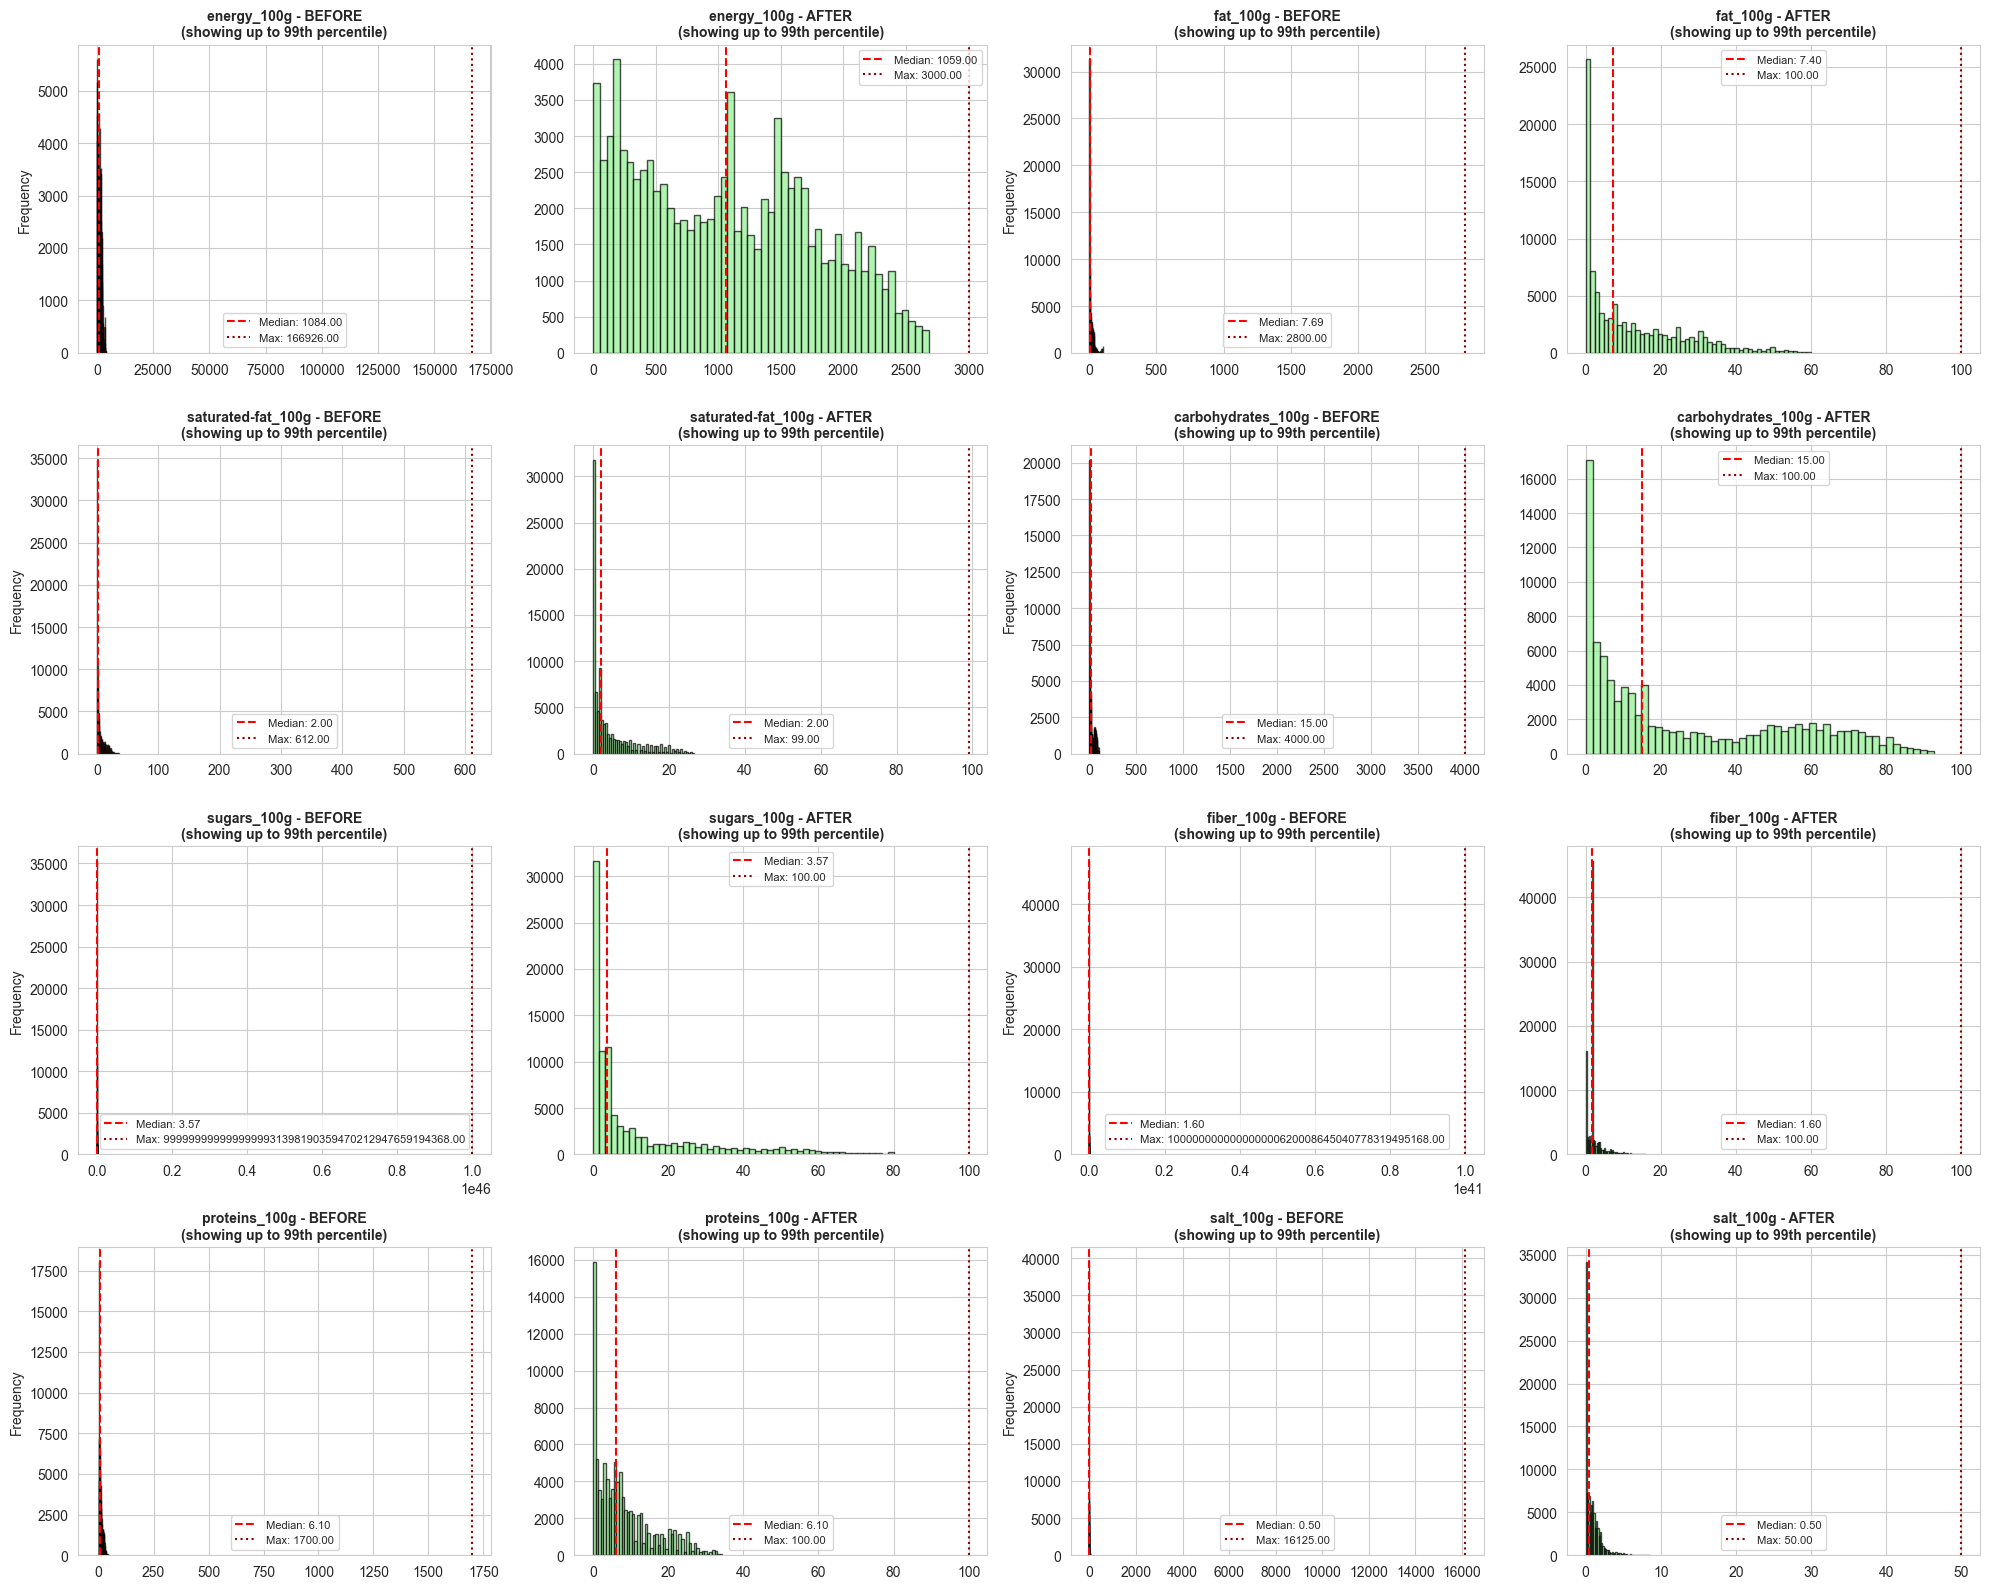

In [7]:
# Create comparison visualizations
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for idx, col in enumerate(nutritional_cols):
    # Before (left plot)
    ax_before = axes[idx * 2]
    data_before = df_before[col]
    # Limit to 99th percentile for better visualization
    q99_before = data_before.quantile(0.99)
    data_before_viz = data_before[data_before <= q99_before]
    
    ax_before.hist(data_before_viz, bins=50, alpha=0.7, color='coral', edgecolor='black')
    ax_before.set_title(f'{col} - BEFORE\n(showing up to 99th percentile)', fontweight='bold', fontsize=10)
    ax_before.set_ylabel('Frequency')
    ax_before.axvline(data_before.median(), color='red', linestyle='--', label=f'Median: {data_before.median():.2f}')
    ax_before.axvline(data_before.max(), color='darkred', linestyle=':', label=f'Max: {data_before.max():.2f}')
    ax_before.legend(fontsize=8)
    
    # After (right plot)
    ax_after = axes[idx * 2 + 1]
    data_after = df_after[col]
    q99_after = data_after.quantile(0.99)
    data_after_viz = data_after[data_after <= q99_after]
    
    ax_after.hist(data_after_viz, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
    ax_after.set_title(f'{col} - AFTER\n(showing up to 99th percentile)', fontweight='bold', fontsize=10)
    ax_after.axvline(data_after.median(), color='red', linestyle='--', label=f'Median: {data_after.median():.2f}')
    ax_after.axvline(data_after.max(), color='darkred', linestyle=':', label=f'Max: {data_after.max():.2f}')
    ax_after.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 5. Box Plots Comparison

Box plots showing the reduction in outliers.

C:\Users\cesar\AppData\Local\Temp\ipykernel_17244\3475600823.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Before', 'After'], patch_artist=True)
C:\Users\cesar\AppData\Local\Temp\ipykernel_17244\3475600823.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Before', 'After'], patch_artist=True)
C:\Users\cesar\AppData\Local\Temp\ipykernel_17244\3475600823.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['Before', 'After'], patch_artist=True)
C:\Users\cesar\AppData\Local\Temp\ipykernel_17244\34

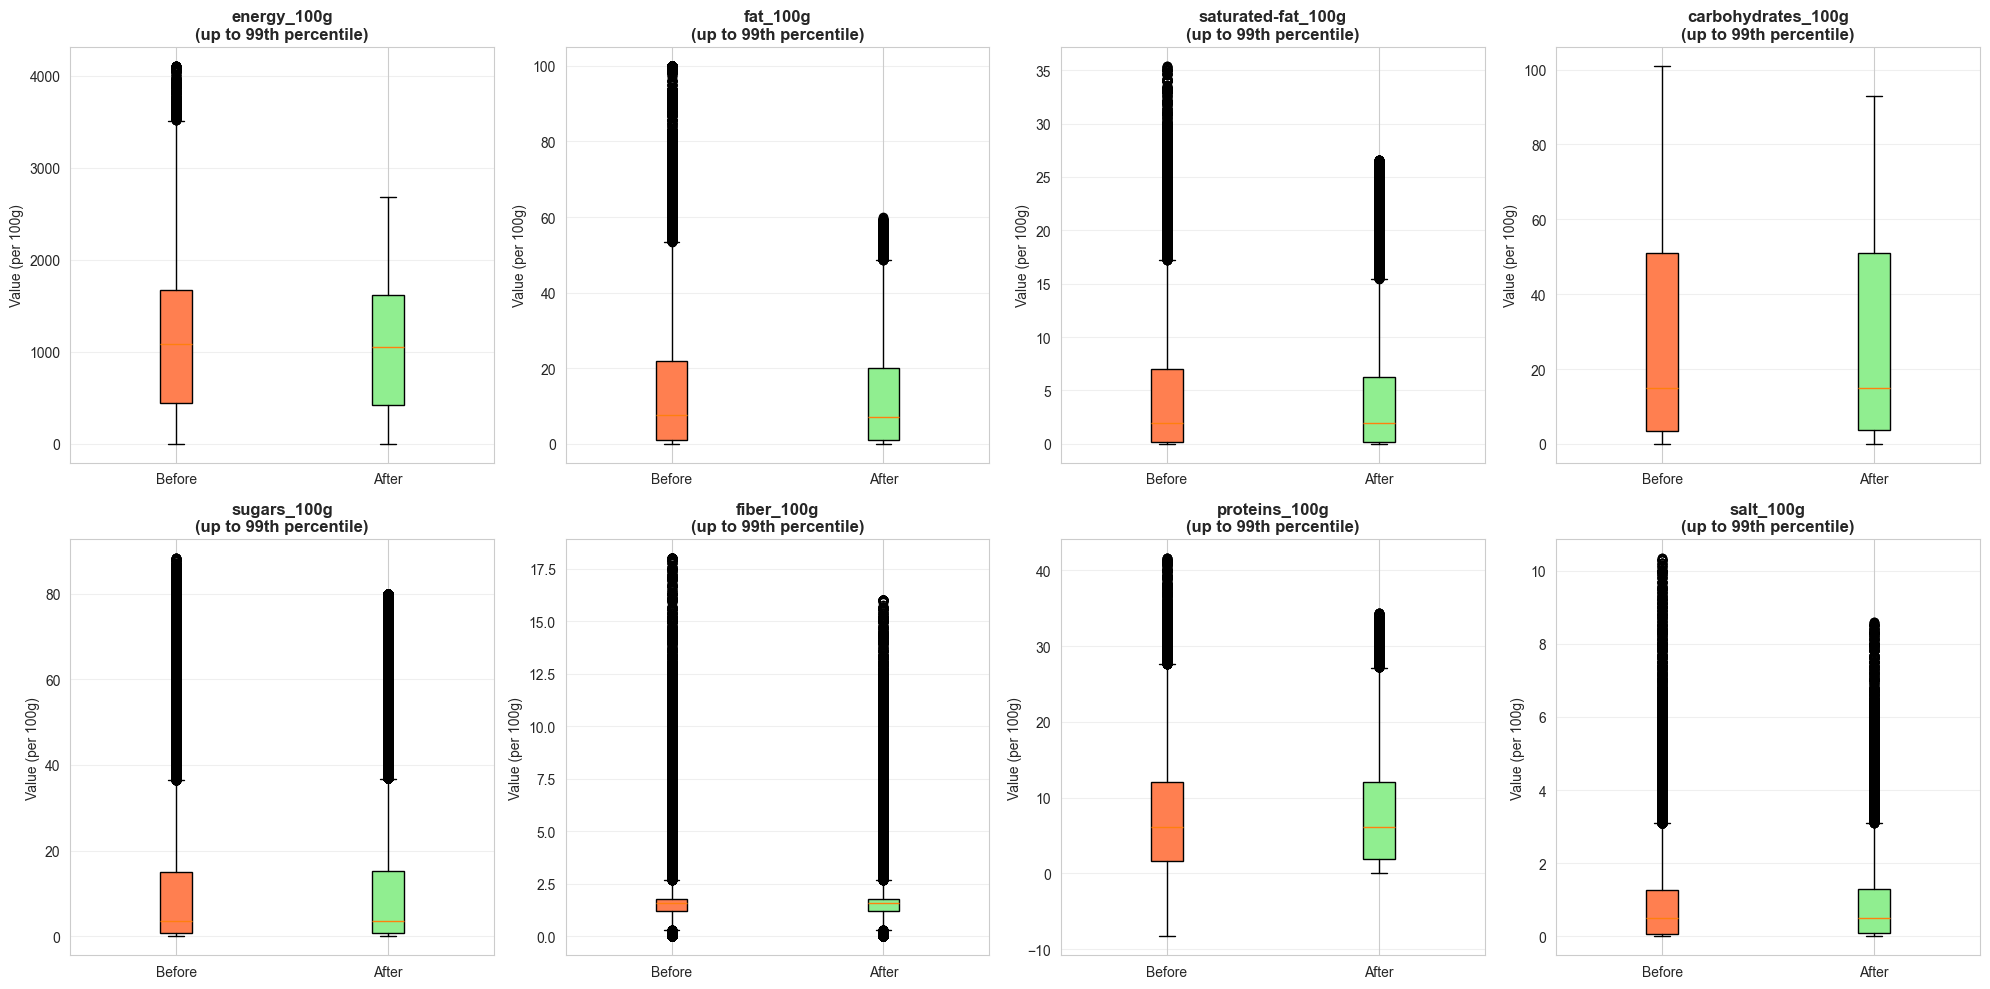

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for idx, col in enumerate(nutritional_cols):
    ax = axes[idx]
    
    # Create data for box plot
    data_to_plot = [
        df_before[col][df_before[col] <= df_before[col].quantile(0.99)],
        df_after[col][df_after[col] <= df_after[col].quantile(0.99)]
    ]
    
    bp = ax.boxplot(data_to_plot, labels=['Before', 'After'], patch_artist=True)
    bp['boxes'][0].set_facecolor('coral')
    bp['boxes'][1].set_facecolor('lightgreen')
    
    ax.set_title(f'{col}\n(up to 99th percentile)', fontweight='bold')
    ax.set_ylabel('Value (per 100g)')
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Validation Checks

Verify that all invalid values have been removed.

In [9]:
print("\nValidation Checks (After Cleaning):")
print("="*70)

# Check for negative values
print("\n1. Negative Values Check:")
for col in nutritional_cols:
    negative_count = (df_after[col] < 0).sum()
    if negative_count > 0:
        print(f"   ⚠️  {col:30s}: {negative_count:,} negative values")
    else:
        print(f"    {col:30s}: No negative values")

# Check for impossible values
print("\n2. Impossible Values Check (macros >100g per 100g):")
for col in ['fat_100g', 'carbohydrates_100g', 'proteins_100g', 'fiber_100g']:
    impossible_count = (df_after[col] > 100).sum()
    if impossible_count > 0:
        max_val = df_after[col].max()
        print(f"   ⚠️  {col:30s}: {impossible_count:,} values > 100g (max: {max_val:.2f}g)")
    else:
        print(f"    {col:30s}: All values <= 100g (max: {df_after[col].max():.2f}g)")

# Check energy range
print("\n3. Energy Range Check (0-3000 kcal/100g):")
energy_invalid = ((df_after['energy_100g'] < 0) | (df_after['energy_100g'] > 3000)).sum()
if energy_invalid > 0:
    print(f"   ⚠️  {energy_invalid:,} values outside valid range")
else:
    print(f"    All energy values valid (max: {df_after['energy_100g'].max():.2f} kcal)")

# Check salt range
print("\n4. Salt Range Check (0-50g per 100g):")
salt_invalid = ((df_after['salt_100g'] < 0) | (df_after['salt_100g'] > 50)).sum()
if salt_invalid > 0:
    print(f"   ⚠️  {salt_invalid:,} values outside valid range")
else:
    print(f"    All salt values valid (max: {df_after['salt_100g'].max():.2f}g)")

# Target variable check
print("\n5. Target Variable Check:")
print(f"    Target variable complete: {df_after['nutriscore_grade'].notna().all()}")
print(f"    Class distribution preserved:")
print(f"\n{df_after['nutriscore_grade'].value_counts().sort_index()}")


Validation Checks (After Cleaning):

1. Negative Values Check:
    energy_100g                   : No negative values
    fat_100g                      : No negative values
    saturated-fat_100g            : No negative values
    carbohydrates_100g            : No negative values
    sugars_100g                   : No negative values
    fiber_100g                    : No negative values
    proteins_100g                 : No negative values
    salt_100g                     : No negative values

2. Impossible Values Check (macros >100g per 100g):
    fat_100g                      : All values <= 100g (max: 100.00g)
    carbohydrates_100g            : All values <= 100g (max: 100.00g)
    proteins_100g                 : All values <= 100g (max: 100.00g)
    fiber_100g                    : All values <= 100g (max: 100.00g)

3. Energy Range Check (0-3000 kcal/100g):
    All energy values valid (max: 3000.00 kcal)

4. Salt Range Check (0-50g per 100g):
    All salt values valid (max: 5

## 7. Max Value Comparison

Compare maximum values before and after outlier removal.

In [10]:
comparison_df = pd.DataFrame({
    'Feature': nutritional_cols,
    'Max Before': [df_before[col].max() for col in nutritional_cols],
    'Max After': [df_after[col].max() for col in nutritional_cols],
    'Median Before': [df_before[col].median() for col in nutritional_cols],
    'Median After': [df_after[col].median() for col in nutritional_cols]
})

comparison_df['Max Reduction (%)'] = ((comparison_df['Max Before'] - comparison_df['Max After']) / comparison_df['Max Before'] * 100).round(2)

print("\nMax Value Comparison:")
print("="*70)
print(comparison_df.to_string(index=False))


Max Value Comparison:
           Feature   Max Before  Max After  Median Before  Median After  Max Reduction (%)
       energy_100g 1.669260e+05     3000.0    1084.000000   1059.000000              98.20
          fat_100g 2.800000e+03      100.0       7.690000      7.400000              96.43
saturated-fat_100g 6.120000e+02       99.0       2.000000      2.000000              83.82
carbohydrates_100g 4.000000e+03      100.0      15.000000     15.000000              97.50
       sugars_100g 1.000000e+46      100.0       3.571429      3.571429             100.00
        fiber_100g 1.000000e+41      100.0       1.600000      1.600000             100.00
     proteins_100g 1.700000e+03      100.0       6.100000      6.100000              94.12
         salt_100g 1.612500e+04       50.0       0.500000      0.500000              99.69


## Summary

### Outlier Removal Strategy

1. **Domain-Specific Rules Applied:**
   - Energy: 0-3000 kcal per 100g
   - Macronutrients (fat, carbs, protein, fiber): 0-100g per 100g
   - Salt: 0-50g per 100g
   - Removed all negative values

2. **Statistical Methods:**
   - IQR method (3× IQR threshold) for extreme statistical outliers
   - Conservative approach to preserve data while removing obvious errors

3. **Results:**
   - Removed 3,903 rows (3.90% of dataset)
   - Final dataset: 96,097 rows × 20 columns
   - All invalid values successfully removed
   - Data distributions significantly improved
   - Target variable distribution preserved

### Data Quality Improvements

- No negative nutritional values
- No impossible values (>100g per 100g for macros)
- Energy values within realistic range (0-3000 kcal)
- Salt values within realistic range (0-50g)
- Statistical distributions more normalized
- Dataset ready for feature engineering

### Next Steps

The cleaned dataset is ready for:
- Feature normalization/scaling
- Categorical variable encoding
- Derived feature creation
- PCA dimensionality reduction
- Train/val/test split